<a href="https://colab.research.google.com/github/ducpb/dog-cat-kaggle/blob/master/test_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2
)
val_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
batch_size = 20
height, width = (150,150)

train_generator = train_datagen.flow_from_directory(
        './drive/My Drive/Colab Notebooks/data/train',
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        './drive/My Drive/Colab Notebooks/data/validation',
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
from tensorflow.keras.applications.vgg16 import VGG16

In [0]:
pre_trained_model = VGG16(input_shape=(150,150,3), include_top=False, weights=None)
pre_trained_model.load_weights('./drive/My Drive/Colab Notebooks/model_trained/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [0]:
for layer in pre_trained_model.layers:
  layer.trainable = False
  
flag = False
for layer in pre_trained_model.layers:
  if flag:
    layer.trainable = True
  if layer.name == 'block5_conv1':
    flag = True

last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output

In [8]:
x = layers.Flatten()(last_output)
x = layers.Dense(1028, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1028, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(2, activation='softmax')(x)
model = Model(pre_trained_model.input, x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [0]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.00001), metrics=['acc'])

In [10]:
from tensorflow.keras import callbacks 

early_stopping = callbacks.EarlyStopping(monitor='val_loss',patience=10, verbose=1)
best_model = callbacks.ModelCheckpoint(filepath='best_model.h5',monitor='val_loss',save_best_only=True, verbose=1)

H = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[early_stopping, best_model],
      verbose=2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.47999, saving model to best_model.h5
100/100 - 23s - loss: 0.7163 - acc: 0.5725 - val_loss: 0.4800 - val_acc: 0.8210
Epoch 2/50

Epoch 00002: val_loss improved from 0.47999 to 0.39795, saving model to best_model.h5
100/100 - 23s - loss: 0.5753 - acc: 0.7040 - val_loss: 0.3980 - val_acc: 0.8220
Epoch 3/50

Epoch 00003: val_loss improved from 0.39795 to 0.30966, saving model to best_model.h5
100/100 - 23s - loss: 0.4819 - acc: 0.7585 - val_loss: 0.3097 - val_acc: 0.8640
Epoch 4/50

Epoch 00004: val_loss improved from 0.30966 to 0.30109, saving model to best_model.h5
100/100 - 24s - loss: 0.4319 - acc: 0.8070 - val_loss: 0.3011 - val_acc: 0.8670
Epoch 5/50

Epoch 00005: val_loss improved from 0.30109 to 0.25826, saving model to best_model.h5
100/100 - 24s - loss: 0.3954 - acc: 0.8190 - val_loss: 0.2583 - val_acc: 0.8860
Epoch 6/50

Epoch 00006: val_loss did 

Text(0.5, 1.0, 'Training and validation loss')

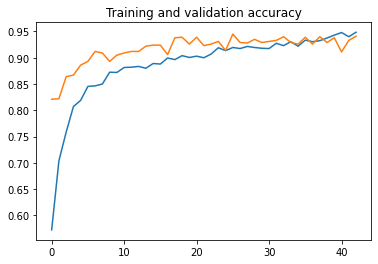

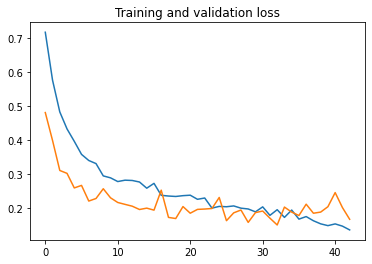

In [17]:
acc = H.history['acc']
val_acc = H.history['val_acc']
loss = H.history['loss']
val_loss = H.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [0]:
from tensorflow.keras.models import load_model
model = load_model('best_model.h5')

In [25]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=r'./drive/My Drive/Colab Notebooks/data/test1',
    target_size=(150, 150),
    batch_size=1,
    class_mode=None,
    shuffle=False,
)

Found 1000 images belonging to 1 classes.


1000
(150, 150, 3)


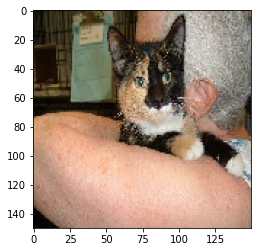

In [26]:
print(len(test_generator))
print(test_generator[0][0].shape)
plt.imshow(test_generator[0][0])

In [27]:
predict = model.predict(test_generator[0][0].reshape(1,150,150,3))
print('Predict Cat:Dog  :', predict)

Predict Cat:Dog  : [[0.9939902  0.00600984]]


In [29]:
score = model.evaluate_generator(validation_generator, verbose=1, steps=50)
print(score)

50/50 [==============================] - 4s 87ms/step - loss: 0.1608 - acc: 0.9330
[0.16083362698554993, 0.9330000281333923]


In [30]:
test_generator.reset()
scores = model.predict_generator(test_generator, verbose=1, steps=1000)
print(scores)

Instructions for updating:
Please use Model.predict, which supports generators.
1000/1000 [==============================] - 765s 765ms/step
[[9.9399018e-01 6.0098418e-03]
 [9.9999988e-01 1.5792956e-07]
 [9.6049523e-01 3.9504822e-02]
 ...
 [1.8512353e-02 9.8148763e-01]
 [1.8567249e-08 1.0000000e+00]
 [5.2742040e-01 4.7257960e-01]]


In [31]:
correct = 0
for i, n in enumerate(test_generator.filenames):
    if n.find("cat") != -1 and scores[i][0] > 0.5:
        correct += 1
    if n.find("dog") != -1 and scores[i][0] <= 0.5:
        correct += 1

print("Correct:", correct, " Total: ", len(test_generator.filenames))

Correct: 928  Total:  1000


In [33]:
test_generator.reset()
pred=model.predict_generator(test_generator,verbose=1, steps=1000)

1000/1000 [==============================] - 8s 8ms/step


In [0]:
predicted_class_indices=np.argmax(pred,axis=1)

In [0]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [0]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames, "Predictions":predictions})
results.to_csv("results.csv",index=False)